# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from plotnine import ggplot, aes, geom_tile, geom_text, scale_fill_gradient, labs, theme_minimal, theme, element_text, geom_line, geom_abline
from IPython.display import display

In [40]:
penguins = sns.load_dataset("penguins")

df = penguins.dropna(subset=["species"]).copy()

X = df.drop(columns=["species"])
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [41]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

In [42]:
models = {
    "kNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "kNN (k=10)": KNeighborsClassifier(n_neighbors=10),
    "Decision Tree (depth=3)": DecisionTreeClassifier(max_depth=3, random_state=42),
    "Decision Tree (depth=None)": DecisionTreeClassifier(random_state=42)
}


=== kNN (k=3) ===
Accuracy: 0.988
              precision    recall  f1-score   support

      Adelie      0.971     1.000     0.986        34
   Chinstrap      1.000     1.000     1.000        17
      Gentoo      1.000     0.971     0.986        35

    accuracy                          0.988        86
   macro avg      0.990     0.990     0.990        86
weighted avg      0.989     0.988     0.988        86



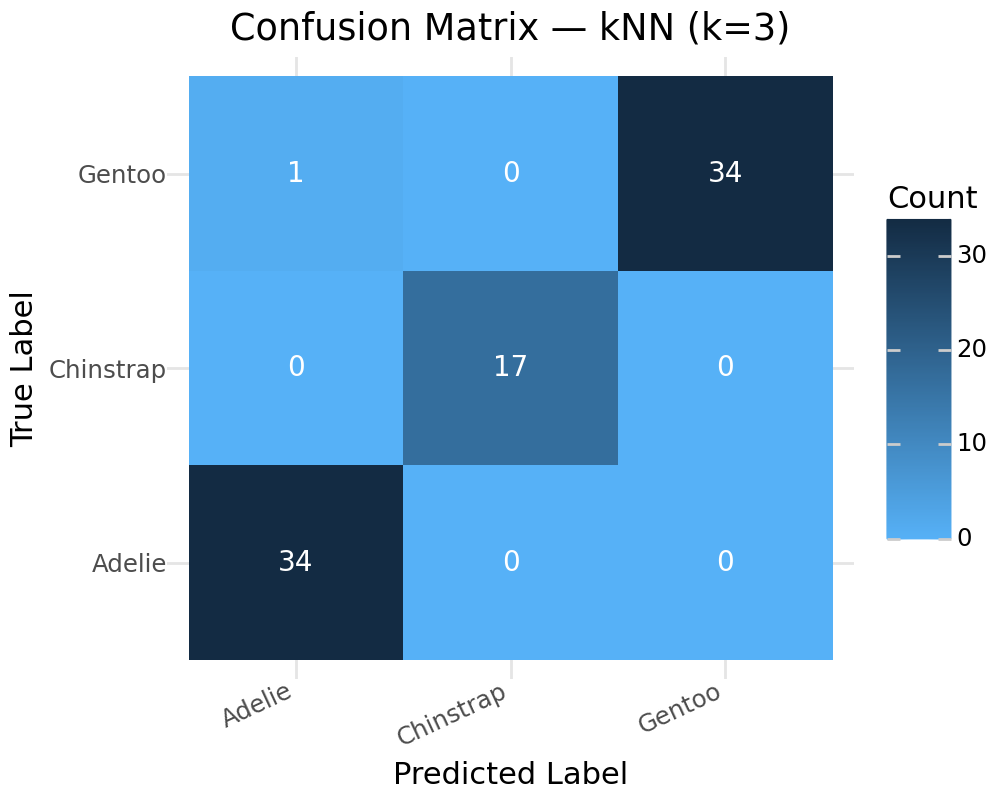


=== kNN (k=10) ===
Accuracy: 0.988
              precision    recall  f1-score   support

      Adelie      0.971     1.000     0.986        34
   Chinstrap      1.000     1.000     1.000        17
      Gentoo      1.000     0.971     0.986        35

    accuracy                          0.988        86
   macro avg      0.990     0.990     0.990        86
weighted avg      0.989     0.988     0.988        86



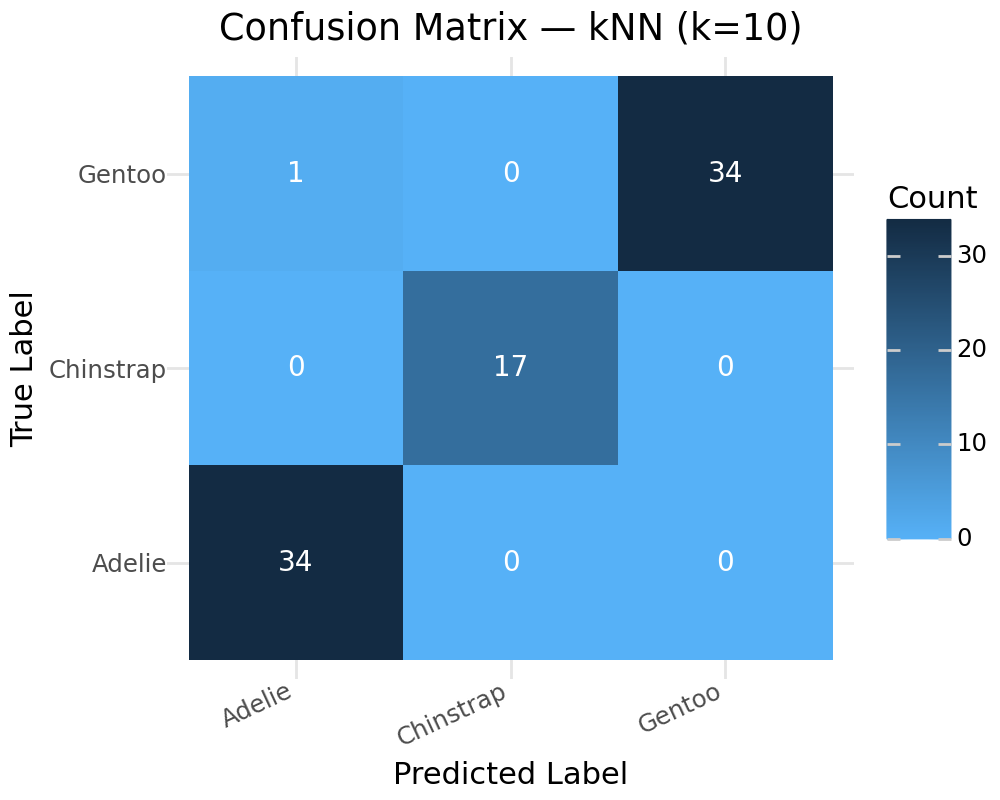


=== Decision Tree (depth=3) ===
Accuracy: 0.977
              precision    recall  f1-score   support

      Adelie      0.944     1.000     0.971        34
   Chinstrap      1.000     0.941     0.970        17
      Gentoo      1.000     0.971     0.986        35

    accuracy                          0.977        86
   macro avg      0.981     0.971     0.976        86
weighted avg      0.978     0.977     0.977        86



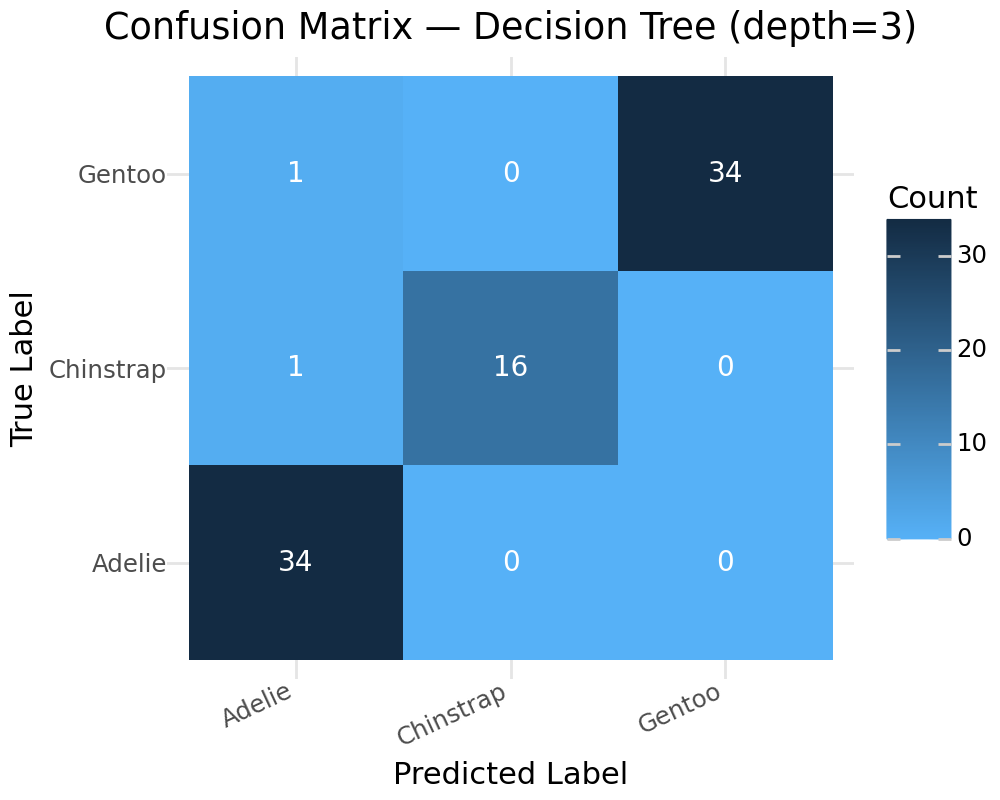


=== Decision Tree (depth=None) ===
Accuracy: 0.977
              precision    recall  f1-score   support

      Adelie      0.971     0.971     0.971        34
   Chinstrap      0.944     1.000     0.971        17
      Gentoo      1.000     0.971     0.986        35

    accuracy                          0.977        86
   macro avg      0.972     0.981     0.976        86
weighted avg      0.977     0.977     0.977        86



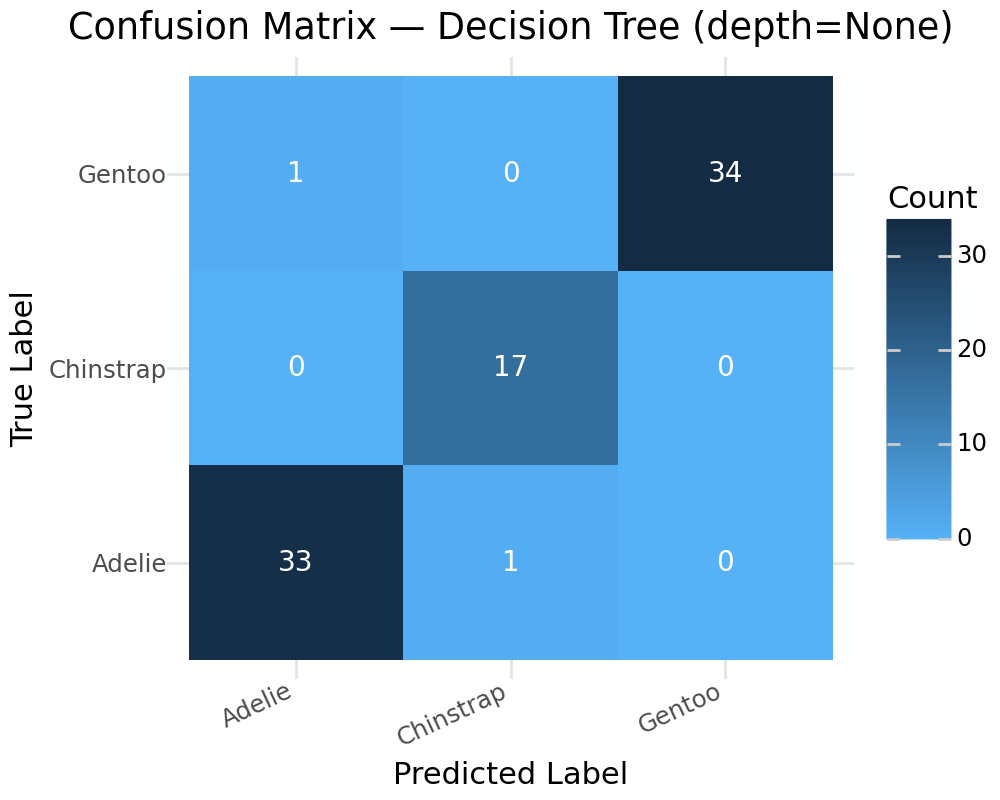


Summary:


,Model,Accuracy
0,kNN (k=3),0.988372
1,kNN (k=10),0.988372
2,Decision Tree (depth=3),0.976744
3,Decision Tree (depth=None),0.976744


In [43]:
results = []

for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    cm_df = (
        pd.DataFrame(cm, index=pipe.classes_, columns=pipe.classes_)
        .reset_index()
        .melt(id_vars="index")
    )
    cm_df.columns = ["True", "Predicted", "Count"]

    # ggplot confusion matrix
    plot = (
        ggplot(cm_df, aes("Predicted", "True", fill="Count"))
        + geom_tile()
        + geom_text(aes(label="Count"), color="white", size=10)
        + scale_fill_gradient(low="#56B1F7", high="#132B43")
        + theme_minimal()
        + labs(
            title=f"Confusion Matrix — {name}",
            x="Predicted Label",
            y="True Label"
        )
        + theme(
            axis_text_x=element_text(rotation=25, ha="right"),
            figure_size=(5, 4)
        )
    )
    display(plot)

    results.append({"Model": name, "Accuracy": acc})

results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("\nSummary:")
display(results_df)



Plotting ROC curve for best model: kNN (k=3)


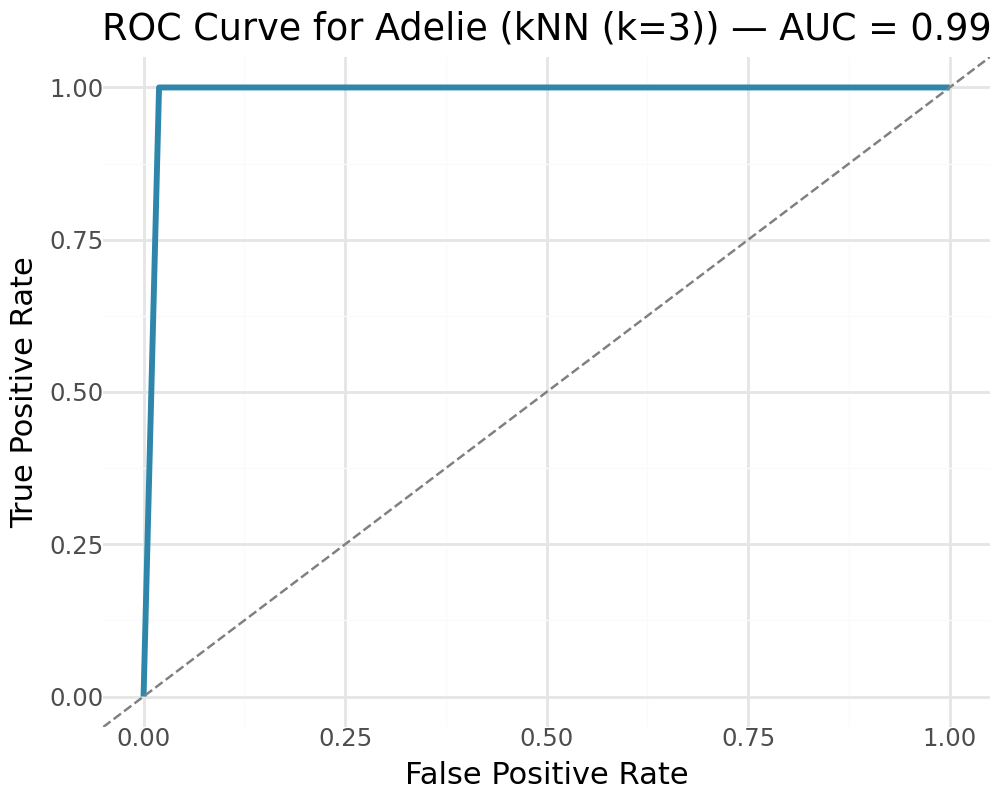

In [44]:
best_name = results_df.iloc[0]["Model"]
print(f"\nPlotting ROC curve for best model: {best_name}")

best_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", models[best_name])
])
best_pipe.fit(X_train, y_train)

classes = y.unique()
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_pipe.predict_proba(X_test)

species = "Adelie"
idx = np.where(classes == species)[0][0]

fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_score[:, idx])
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr})

p_roc = (
    ggplot(roc_df, aes(x="fpr", y="tpr"))
    + geom_line(color="#2E86AB", size=1.2)
    + geom_abline(linetype="dashed", color="gray")
    + theme_minimal()
    + labs(
        title=f"ROC Curve for {species} ({best_name}) — AUC = {roc_auc:.2f}",
        x="False Positive Rate",
        y="True Positive Rate"
    )
    + theme(figure_size=(5, 4))
)

p_roc